# Clasificación de erupciones volcánicas

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV

drive.mount ('/content/drive')
%cd '/content/drive/MyDrive/Reto_preliminar_Hackathon170822/Data/'

Mounted at /content/drive
/content/drive/MyDrive/Reto_preliminar_Hackathon170822/Data


In [17]:
df = pd.read_csv('jm_train.csv')
df

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0
...,...,...,...,...,...,...,...
2095,-0.947002,0.174969,-0.180249,0.118236,-0.143420,-0.359509,0
2096,-1.224148,0.029956,0.536684,0.888406,0.119460,0.378946,1
2097,-0.847593,1.538574,0.962409,1.966467,0.379934,0.737907,3
2098,1.472437,1.187695,1.015766,-1.103522,1.586722,0.182569,4


In [3]:
#Miramos si existe alguna celda vacía
df.isnull().sum()

feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
target      0
dtype: int64

In [4]:
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


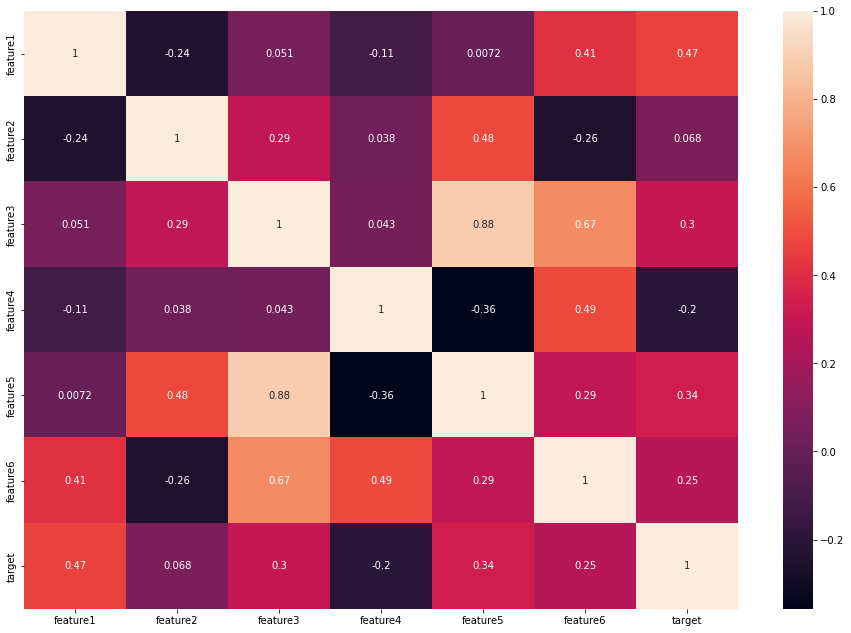

In [33]:
fig = plt.figure(figsize=(16,11))
sns.heatmap(df.corr(), annot=True)

In [5]:
#Comprovamos si las variables siguien una distribución normal 
l={}
t = False
for i in df.columns:
  stat, p = shapiro(df[i])
  if p > 0.05:
    l[i] = p
    t = True

if t:
  print(f'La/las variables probables de que tengan una distribución gausiana son las siguientes:\n\n{l}')
else:
  print('Ninguna variable tiene una distribución normal')

Ninguna variable tiene una distribución normal


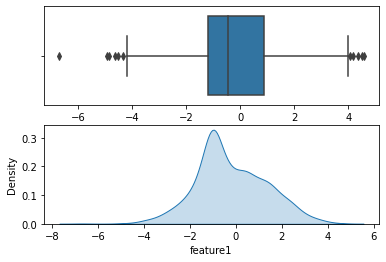

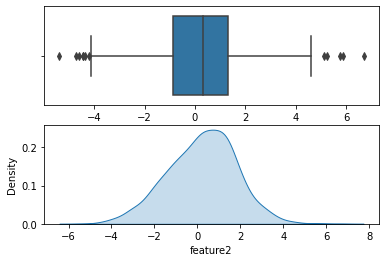

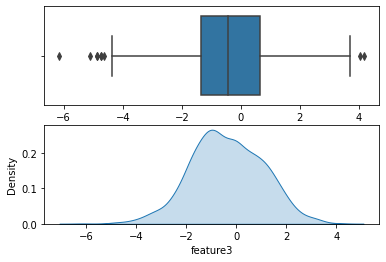

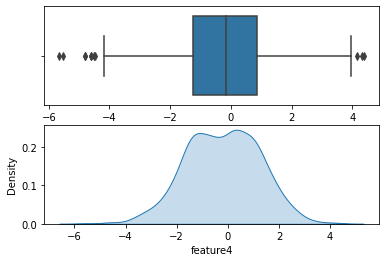

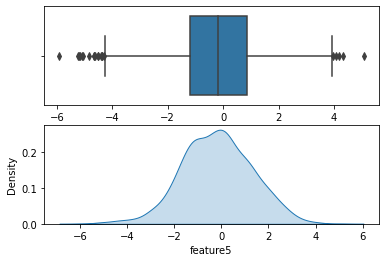

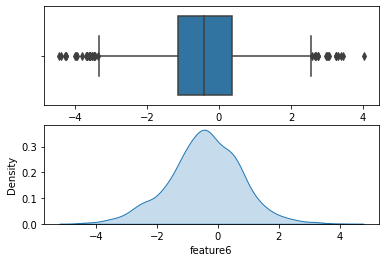

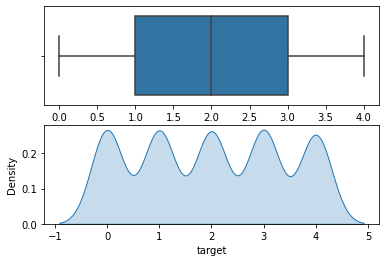

In [6]:
# Miramos si hay outliers gracias a los boxplot
warnings.filterwarnings('ignore')

for i in df.columns:
  f, (ax_box, ax_kde) = plt.subplots(2)
  sns.boxplot(df[i], ax = ax_box)
  sns.kdeplot(df[i], ax = ax_kde, fill=True)

Como todas las variables independientes contienen outliers, utilizaremos el algoritmo de Robust Scaler ya que tiene en cuenta los outliers a la hora de tranformar los datos.

Para poder tener una aproximación del f1-score del modelo, usaremos el df 'jm_train' para hacer train test split para poder tener variables dependientes en el test i poder obtener la calidad de la predicción. Este valor será aproximado ya que el modelo que se use para obtener el target de df 'jm_X_test' será entrenado con la totalidad de la base de datos de 'jm_train', en lugar del 80%.

In [34]:
X_train = df.drop(columns = ['target', 'feature5'])
y_train = df.target

In [35]:
columns = X_train.columns
X_train[columns] = RobustScaler().fit(X_train).transform(X_train)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=45)

In [54]:
params = {'n_estimators': range(200, 2000, 10),
               'max_features': ['auto', 'sqrt'],
               'max_depth': range(10, 100),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [41]:
#Buscamos los mejores parámetros para el modelo 

rf = RandomForestClassifier(max_features='auto').fit(X_train, y_train)
rf_bp = RandomizedSearchCV(rf, params, cv=5).fit(X_train, y_train)
pred = rf_bp.predict(X_test)
f1 = f1_score(y_test, pred, average='macro')
print(f1)

0.8236751490564878


Con una puntuación de 0.82 podemos considerar que nuestro modelo es bueno

In [59]:
#Importamos el df para el test
df_test = pd.read_csv('jm_X_test.csv')
df_test

,feature1,feature2,feature3,feature4,feature5,feature6
0,0.943723,-2.985473,-0.938218,3.580261,-3.038106,2.080338
1,-0.899819,1.295568,1.274513,0.718186,1.117035,0.463068
2,0.293281,-0.099317,1.874902,-0.589582,1.828441,1.011596
3,-1.134804,0.888585,-1.464499,-1.183056,-0.525729,-1.963822
4,-0.909240,1.575797,0.697212,1.197092,0.486185,0.222644
...,...,...,...,...,...,...
895,0.196663,-0.866822,-1.132836,-0.700726,-0.886717,-0.680351
896,1.306644,0.543675,0.555275,-0.518374,0.796236,0.297632
897,-1.009089,0.359536,-2.253087,0.125687,-1.881437,-1.704497
898,-0.339431,-0.560891,-0.256911,-1.576351,0.317480,-0.742085


In [60]:
df_test.isnull().sum()

feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
dtype: int64

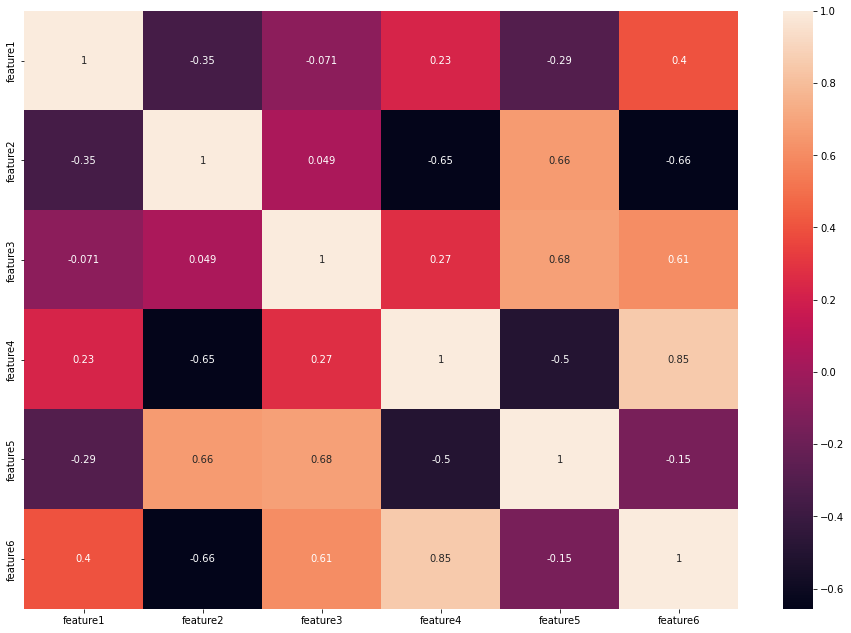

In [61]:
fig = plt.figure(figsize=(16,11))
sns.heatmap((df_test.iloc[:17]).corr(), annot=True)

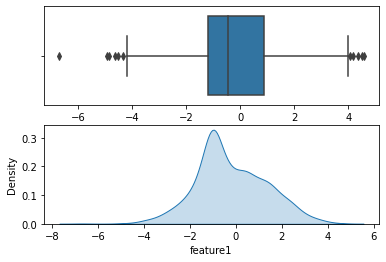

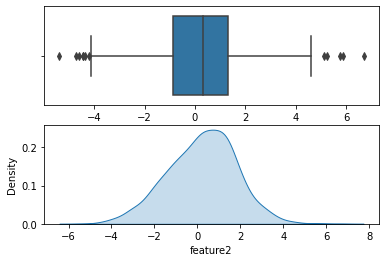

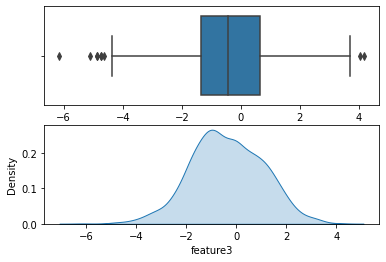

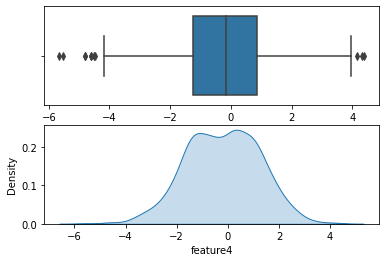

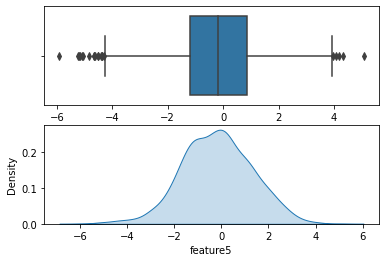

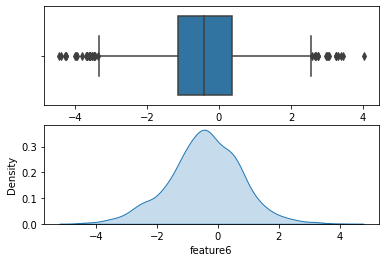

In [67]:
# Miramos si hay outliers gracias a los boxplot
warnings.filterwarnings('ignore')

for i in df_test.columns:
  f, (ax_box, ax_kde) = plt.subplots(2)
  sns.boxplot(df[i], ax = ax_box)
  sns.kdeplot(df[i], ax = ax_kde, fill=True)

In [62]:
#Utilizamos el mismo algoritmo de transformación ya que nos encontramos en la misma situación que antes
columns = df_test.columns
df_test[columns] = RobustScaler().fit(df_test).transform(df_test)

In [63]:
#Entrenamos ahora el modelo con todo el df de 'jm_train'
X_train = df.drop(columns = ['target'])
y_train = df.target

rf = RandomForestClassifier().fit(X_train, y_train)
rf_bp = RandomizedSearchCV(rf, params, cv=5).fit(X_train, y_train)
pred = rf_bp.predict(df_test)

In [64]:
#Guardamos los resultados en un df
prediction = pd.DataFrame(pred, columns=['label'])
prediction

,label
0,1
1,4
2,2
3,4
4,3
...,...
895,3
896,4
897,4
898,3


In [66]:
#Lo exportamos como .csv
prediction.to_csv('Prediction.csv', index=False)